## Click detection CNN model training

In [1]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import importlib
import platform


This notebook is designed to run on both a local MacOS-based system and Google Colab to utilize the available computing power for model training.

To run the notebook on Google Colab, the similar folder sctructure is required as for the local run with the subfolders and files for the datasets, model architecture, weights etc.

### Directory structure
Audio file dataset folders are in the subfolder "01_audioDatasets/..." <br>
("01_audioDatasets" folder is excluded from git, the relative path to this folder is in the gitignore file)<br>

In case of new dataset --> new folder in "01_Data/01_audioDatasets/"

```
01_Electrical_Connector_Click-Event_Detection_git_repo/
└─── 01_Dataset
    └─── 01_audioDatasets (excluded from git)
        ├─── 01_Ethernet
        ├─── 02_Ethernet_test
        ├─── ...
        ├─── 07_Noise_samples
        ├─── [New dataset folders go here]
        
    └─── preprocessNoiseAudio.ipynb
    └─── ...
└─── ...
```

In [2]:
# define op system
system = platform.system()
system

# outputs: for MacOS: 'Darwin', for Linux: 'Linux'

'Linux'

### 1. Import data and create the training, validation and test dataset

In [3]:
# import data from selected dataset

audio_datasets = []
audio_datasets_augmented = []

if system == 'Darwin':
    cwd = str(Path.cwd())
    parent_dir = os.path.dirname(cwd)
    audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
    audio_datasets_main_dir_path = os.path.join(parent_dir, audio_datasets_main_dir)

    audio_datasets_augemnted_dir = "02_Data_Augmentation/01_augmentedDatasets"
    audio_datasets_augemnted_dir_path = os.path.join(parent_dir, audio_datasets_augemnted_dir)

    if os.path.exists(audio_datasets_main_dir_path):
        for i in os.listdir(audio_datasets_main_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets.append(i)
        audio_datasets = sorted(audio_datasets)
    else:
        print("Audio dataset directory does not exist")

    if os.path.exists(audio_datasets_augemnted_dir_path):
        for i in os.listdir(audio_datasets_augemnted_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets_augmented.append(i)
        audio_datasets_augmented = sorted(audio_datasets_augmented)
    else:
        print("Augmented audio dataset directory does not exist")

 # google colab
if system == "Linux":
    from google.colab import drive
    # if drive not mounted
    if not os.path.exists("/content/drive"):
        drive.mount("/content/drive")
    cwd = str(Path.cwd())
    audio_datasets_main_dir_path = os.path.join(cwd, 'drive/MyDrive/Masters_thesis_clickSense/01_Dataset/01_audioDatasets')
    audio_datasets_augemnted_dir_path = os.path.join(cwd, 'drive/MyDrive/Masters_thesis_clickSense/02_Data_Augmentation/01_augmentedDatasets')
    print(audio_datasets_main_dir_path)

    if os.path.exists(audio_datasets_main_dir_path):
        for i in os.listdir(audio_datasets_main_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets.append(i)
        audio_datasets = sorted(audio_datasets)
    else:
        print("Audio dataset directory does not exist")

    if os.path.exists(audio_datasets_augemnted_dir_path):
        for i in os.listdir(audio_datasets_augemnted_dir_path):
            #if folder name does not start with a dot
            if i[0] != ".":
                audio_datasets_augmented.append(i)
        audio_datasets_augmented = sorted(audio_datasets_augmented)
    else:
        print("Augmented audio dataset directory does not exist")

print(audio_datasets)
print(audio_datasets_augmented)

Mounted at /content/drive
/content/drive/MyDrive/Masters_thesis_clickSense/01_Dataset/01_audioDatasets
['01_Ethernet', '02_Ethernet_Test', '03_HVA280', '04_HVA280_Test', '05_HVA630', '06_HVA630_Test', '07_Noise_Samples']
['01_Ethernet', '02_HVA280', '03_HVA630', '04_Noise_Samples']


In [4]:
datasets = []
datasets_augmented = []

dataset_id = 0 # ID of the selected datasets, 0 - ethernet, 2 - hva 280, 4 - hva 630

if dataset_id == 0:
    dataset_augmented_id = 0
elif dataset_id == 2:
    dataset_augmented_id = 1
elif dataset_id == 4:
    dataset_augmented_id = 2

long_window = False
if dataset_id == 2:
    long_window = True

noise_dataset_id = 6
noise_dataset_augmented_id = 3

datasets.append(dataset_id)
datasets.append(noise_dataset_id)

datasets_augmented.append(dataset_augmented_id)
datasets_augmented.append(noise_dataset_augmented_id)

print(f"datasets: {datasets}")
print(f"augmented datasets: {datasets_augmented}")

loaded_spec_chunks = None
loaded_spec_chunk_labels = None



for i in datasets:
    dataset_dir_path = os.path.join(audio_datasets_main_dir_path, audio_datasets[i])
    file_list = []

    for f in os.listdir(dataset_dir_path):
        if i == 6 and f.endswith('.npz'):
            if long_window and "long" in f:
                file_list.append(f)
            elif not long_window and "long" not in f:
                file_list.append(f)
        elif f.endswith('.npz'):
            file_list.append(f)

    print(file_list)

    if len(file_list) == 0:
        print(f"No npz file in the directory {audio_datasets[i]}")
    else:
        for file in file_list:
            file_fullpath = os.path.join(dataset_dir_path, file)

            data = np.load(file_fullpath)

            if loaded_spec_chunks is None:
                loaded_spec_chunks = data['spec_chunks']
                loaded_spec_chunk_labels = data['labels']
            else:
                loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)
                loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)

for i in datasets_augmented:
    dataset_augmented_dir_path = os.path.join(audio_datasets_augemnted_dir_path, audio_datasets_augmented[i])
    file_list = []

    for f in os.listdir(dataset_augmented_dir_path):
        if i == 3 and f.endswith('.npz'):
            if long_window and "long" in f:
                file_list.append(f)
            elif not long_window and "long" not in f:
                file_list.append(f)
        elif f.endswith('.npz'):
            file_list.append(f)

    print(file_list)
    if len(file_list) == 0:
        print(f"No npz file in the directory {audio_datasets_augmented[i]}")
    else:
        for file in file_list:
            file_fullpath = os.path.join(dataset_augmented_dir_path, file)

            data = np.load(file_fullpath)

            if loaded_spec_chunks is None:
                loaded_spec_chunks = data['spec_chunks']
                loaded_spec_chunk_labels = data['labels']
            else:
                loaded_spec_chunks = np.concatenate((loaded_spec_chunks, data['spec_chunks']), axis=0)
                loaded_spec_chunk_labels = np.concatenate((loaded_spec_chunk_labels, data['labels']), axis=0)

# check dataset information
print(loaded_spec_chunks[0].shape)
print(f"number of spectrogram chunks: {len(loaded_spec_chunks)}")

# check number of 1s and 0s in the labels
print(f"positive samples: {np.count_nonzero(loaded_spec_chunk_labels == 1)}")
print(f"negative samples: {np.count_nonzero(loaded_spec_chunk_labels == 0)}")


datasets: [0, 6]
augmented datasets: [0, 3]
['ethernet_dataset.npz']
['noise_dataset.npz']
['ethernet_dataset_augmented_w_recorded_noise.npz', 'ethernet_dataset_augmented_w_generated_noise.npz']
['noise_dataset_generated.npz']
(128, 32)
number of spectrogram chunks: 21872
positive samples: 5604
negative samples: 16268


In [5]:
"""# balance the dataset

positive_indices = np.where(loaded_spec_chunk_labels == 1)[0]
negative_indices = np.where(loaded_spec_chunk_labels == 0)[0]

num_positive = len(positive_indices)
num_negative = len(negative_indices)

print(f"Positive samples: {num_positive}")
print(f"Negative samples: {num_negative}")

np.random.seed(42)

if num_negative > num_positive:
    downsampled_negative_indices = np.random.choice(negative_indices, size=num_positive, replace=False)
else:
    downsampled_negative_indices = negative_indices

balanced_indices = np.concatenate([positive_indices, downsampled_negative_indices])

balanced_spec_chunks = loaded_spec_chunks[balanced_indices]
balanced_spec_chunk_labels = loaded_spec_chunk_labels[balanced_indices]



print(f"Number of spectrogram chunks after balancing: {len(balanced_spec_chunks)}")
print(f"Positive samples: {np.count_nonzero(balanced_spec_chunk_labels == 1)}")
print(f"Negative samples: {np.count_nonzero(balanced_spec_chunk_labels == 0)}")"""

'# balance the dataset\n\npositive_indices = np.where(loaded_spec_chunk_labels == 1)[0]\nnegative_indices = np.where(loaded_spec_chunk_labels == 0)[0]\n\nnum_positive = len(positive_indices)\nnum_negative = len(negative_indices)\n\nprint(f"Positive samples: {num_positive}")\nprint(f"Negative samples: {num_negative}")\n\nnp.random.seed(42)\n\nif num_negative > num_positive:\n    downsampled_negative_indices = np.random.choice(negative_indices, size=num_positive, replace=False)\nelse:\n    downsampled_negative_indices = negative_indices\n\nbalanced_indices = np.concatenate([positive_indices, downsampled_negative_indices])\n\nbalanced_spec_chunks = loaded_spec_chunks[balanced_indices]\nbalanced_spec_chunk_labels = loaded_spec_chunk_labels[balanced_indices]\n\n\n\nprint(f"Number of spectrogram chunks after balancing: {len(balanced_spec_chunks)}")\nprint(f"Positive samples: {np.count_nonzero(balanced_spec_chunk_labels == 1)}")\nprint(f"Negative samples: {np.count_nonzero(balanced_spec_chunk

In [6]:
# normalize spectrogram chunks

## update with the decibel scale min max used in real time detection!!!

def normalize_spectrogram_chunks(spec_chunks):
    # find global min and max values
    """global_min = np.min(spec_chunks)
    global_max = np.max(spec_chunks)"""

    # min and max dB values set in the preprocessing notebook
    global_min = -120
    global_max = 0

    print(global_min, global_max)

    normalized_spectrograms = [(spec - global_min) / (global_max - global_min) for spec in spec_chunks]

    return normalized_spectrograms

#balanced_spec_chunks_norm = normalize_spectrogram_chunks(balanced_spec_chunks)

spec_chunks_norm = normalize_spectrogram_chunks(loaded_spec_chunks)

print(spec_chunks_norm[0].shape)
print(np.min(spec_chunks_norm[0]), np.max(spec_chunks_norm[0]))

-120 0
(128, 32)
0.0438104 0.59884274


In [7]:
# split the dataset into training, validation and test sets

# create a dataframe to store the spectrogram chunks and their labels
df_spectrogram_dataset = pd.DataFrame(columns=['spectrogram', 'label'])

# add the spectrogram chunks and their labels to the dataframe
df_spectrogram_dataset['spectrogram'] = spec_chunks_norm
df_spectrogram_dataset['label'] = loaded_spec_chunk_labels

# in case of using the balanced dataset
# df_spectrogram_dataset['label'] = balanced_spec_chunk_labels

print(df_spectrogram_dataset.head())
print(df_spectrogram_dataset[df_spectrogram_dataset.label == 1].head())

# separate positive and negative samples in spec_chunks_norm dataset based on the labels in loaded_spec_chunk_labels
spec_chunks_OK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 1]
spec_chunks_NOK = df_spectrogram_dataset[df_spectrogram_dataset['label'] == 0]

# Function to split a dataframe according to the 60-20-20 ratio
def split_df(df):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)  # test_size = 0.2 --> 80% for training, 20% for validation and testing
    val, test = train_test_split(temp, test_size=0.5, random_state=42)  # 10% for validation, 10% for testing
    return train, val, test

train_OK, val_OK, test_OK = split_df(spec_chunks_OK)
train_NOK, val_NOK, test_NOK = split_df(spec_chunks_NOK)

# Combine the corresponding sets
train_set = pd.concat([train_OK, train_NOK]).sample(frac=1, random_state=42)
val_set = pd.concat([val_OK, val_NOK]).sample(frac=1, random_state=42)
test_set = pd.concat([test_OK, test_NOK]).sample(frac=1, random_state=42)

print(f"Train set size: {len(train_set)}, Validation set size: {len(val_set)}, Test set size: {len(test_set)}")
print(train_set.label.value_counts())
print(val_set.label.value_counts())
print(test_set.label.value_counts())
print(train_set[train_set.label == 1].head())

                                         spectrogram  label
0  [[0.3788925, 0.25929248, 0.26714045, 0.3332723...    0.0
1  [[0.13239302, 0.16194344, 0.07906348, 0.094020...    0.0
2  [[0.16781941, 0.070345685, 0.15296523, 0.19073...    0.0
3  [[0.13016383, 0.12481639, 0.16004111, 0.209296...    0.0
4  [[0.1644024, 0.13420811, 0.13773626, 0.0968164...    0.0
                                           spectrogram  label
176  [[0.20453428, 0.19660683, 0.1803208, 0.2099158...    1.0
177  [[0.21733004, 0.14077899, 0.14537048, 0.109780...    1.0
178  [[0.16921425, 0.047691345, 0.13245894, 0.14110...    1.0
179  [[0.1505352, 0.1640859, 0.11732661, 0.08867721...    1.0
420  [[0.1319903, 0.1413681, 0.1483827, 0.11101411,...    1.0
Train set size: 17497, Validation set size: 2187, Test set size: 2188
label
0.0    13014
1.0     4483
Name: count, dtype: int64
label
0.0    1627
1.0     560
Name: count, dtype: int64
label
0.0    1627
1.0     561
Name: count, dtype: int64
                            

In [8]:
# prepare data for model input --> convert to torch sensors

def prepare_data(df):
    X = np.stack(df['spectrogram'].values)  # convert spectrogram list to numpy array
    #X = np.expand_dims(X, axis=1)  # add channel dimension
    y = df['label'].values
    return X, y

X_train, y_train = prepare_data(train_set)
X_val, y_val = prepare_data(val_set)
X_test, y_test = prepare_data(test_set)

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape, '\n')

# convert to torch tensors
def to_tensor(X, y):
    X = torch.from_numpy(X).type(torch.float32).unsqueeze(1) # convert to torch and add channel dimension
    y = torch.from_numpy(y).type(torch.float32)
    return X, y

X_train_tens, y_train_tens = to_tensor(X_train, y_train)
X_val_tens, y_val_tens = to_tensor(X_val, y_val)
X_test_tens, y_test_tens = to_tensor(X_test, y_test)

# View the first five samples
print(X_train_tens.shape, y_train_tens.shape)
print(X_val_tens.shape, y_val_tens.shape)
print(X_test_tens.shape, y_test_tens.shape)

train data shape: (17497, 128, 32)
train targets shape: (17497,)
val data shape: (2187, 128, 32)
val targets shape: (2187,)
test data shape: (2188, 128, 32)
test targets shape: (2188,) 

torch.Size([17497, 1, 128, 32]) torch.Size([17497])
torch.Size([2187, 1, 128, 32]) torch.Size([2187])
torch.Size([2188, 1, 128, 32]) torch.Size([2188])


In [9]:
# check if GPU is available, if not use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# create dataloaders for training, validation and test sets

BATCH_SIZE = 16

train_dataset = torch.utils.data.TensorDataset(X_train_tens, y_train_tens)
val_dataset = torch.utils.data.TensorDataset(X_val_tens, y_val_tens)
test_dataset = torch.utils.data.TensorDataset(X_test_tens, y_test_tens)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

print(f"Length of train dataloader: {len(train_loader)}")
print(f"Length of test dataloader: {len(val_loader)}")
print(f"Length of test dataloader: {len(test_loader)}")

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

Length of train dataloader: 1094
Length of test dataloader: 137
Length of test dataloader: 137


(torch.Size([16, 1, 128, 32]), torch.Size([16]))

In [11]:
# model architecture
"""
if not long_window:
  selected_model = "ClickDetectorCNN_v1.py"
elif long_window:
  selected_model = "ClickDetectorCNN_v1_long_window.py"

#module = importlib.import_module(architecture_file[:-3])

cwd = str(Path.cwd())
if system == 'Darwin':
  model_architectures_dir = "01_modelArchitectures"
elif system == 'Linux':
  model_architectures_dir = "drive/MyDrive/Masters_thesis_clickSense/03_Click_Detection_Model/01_modelArchitectures"
model_architectures_dir_path = os.path.join(cwd, model_architectures_dir)
print(model_architectures_dir_path)
if os.path.exists(model_architectures_dir_path):
    sys.path.append(model_architectures_dir_path)
    model_module = importlib.import_module(selected_model[:-3])
    #from ClickDetectorCNN_v1 import ClickDetectorCNN
    ClickDetectorCNN = getattr(model_module, 'ClickDetectorCNN') #access the ClickDetectorCNN class
    model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
else:
    print("Model architectures directory does not exist")

model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)
model
"""

'\nif not long_window:\n  selected_model = "ClickDetectorCNN_v1.py"\nelif long_window:\n  selected_model = "ClickDetectorCNN_v1_long_window.py"\n\n#module = importlib.import_module(architecture_file[:-3])\n\ncwd = str(Path.cwd())\nif system == \'Darwin\':\n  model_architectures_dir = "01_modelArchitectures"\nelif system == \'Linux\':\n  model_architectures_dir = "drive/MyDrive/Masters_thesis_clickSense/03_Click_Detection_Model/01_modelArchitectures"\nmodel_architectures_dir_path = os.path.join(cwd, model_architectures_dir)\nprint(model_architectures_dir_path)\nif os.path.exists(model_architectures_dir_path):\n    sys.path.append(model_architectures_dir_path)\n    model_module = importlib.import_module(selected_model[:-3])\n    #from ClickDetectorCNN_v1 import ClickDetectorCNN\n    ClickDetectorCNN = getattr(model_module, \'ClickDetectorCNN\') #access the ClickDetectorCNN class\n    model = ClickDetectorCNN(input_channels=1, output_shape=1).to(device)\nelse:\n    print("Model architectu

In [12]:
# model architecture for hyperparameter optimization

class ClickDetectorCNN(nn.Module):
    def __init__(self, input_channels, output_shape, input_width, input_height, ch1, ch2, kernel_size_1, stride_1, kernel_size_2, stride_2, padding):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels,
                      out_channels=ch1,
                      kernel_size=kernel_size_1,
                      stride=stride_1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_2, stride=stride_2)
        )
        output_width_1 = (input_width - kernel_size_2) // stride_2 + 1
        output_height_1 = (input_height - kernel_size_2) // stride_2 + 1

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=ch1,
                      out_channels=ch2,
                      kernel_size=kernel_size_1,
                      stride=stride_1,
                      padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=kernel_size_2, stride=stride_2)

        )
        output_width_2 = (output_width_1 - kernel_size_2) // stride_2 + 1
        output_height_2 = (output_height_1 - kernel_size_2) // stride_2 + 1

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= ch2 * output_width_2 * output_height_2, ## ch x w x h
                      out_features=output_shape),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

input_height = X_train_tens.shape[2]
input_width = X_train_tens.shape[3]
print(input_height, input_width)

ch1 = [32, 64, 128]
ch2 = [32, 64, 128]

model = ClickDetectorCNN(input_channels=1, output_shape=1, input_width=input_width, input_height=input_height, ch1=ch1[1], ch2=ch2[1], kernel_size_1=3, stride_1=1, kernel_size_2=2, stride_2=2, padding="same")

model.to(device)
model

128 32


ClickDetectorCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)

In [14]:
# model training

best_model_weights_all = None
best_val_loss_all = float('inf')
best_training_params = [] # ch1, ch2, learning_rate
train_losses_best, val_losses_best = [], []

# hyperparameters for optimization
## kernel chanel sizes
channels_1 = [32, 64, 128]
channels_2 = [32, 64, 128]
## learning rates
learning_rates = [1e-2, 1e-3, 1e-4]

binary_threshold = 0.5

loss_fn = nn.BCELoss() # Binary Cross Entropy Loss

epochs = 30

# early stopping parameters
patience = 5  # epochs to wait after last time validation loss improved
delta = 0.001  # minimum change in the validation loss

def accuracy_fn(y_true, y_pred):
        binary_predictions = (y_pred > binary_threshold).float()
        correct = torch.eq(y_true, binary_predictions).sum().item() # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100
        return acc

# model training with hyperparameters optimization
def model_training(ch1, ch2, learning_rate):

    global best_val_loss_all
    global best_model_weights_all
    global best_training_params
    global train_losses_best, val_losses_best

    best_model_weights = None

    #learning_rate = 1e-3

    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')  # initialize best validation loss as infinity
    best_val_acc = 0 # initialize best validation accuracy
    patience_counter = 0  # counter for epochs since last improvement

    train_losses, val_losses = [], []

    def initialize_model_and_optimizer():
        global model, optimizer
        model = ClickDetectorCNN(input_channels=1, output_shape=1, input_width=input_width, input_height=input_height, ch1=ch1, ch2=ch2, kernel_size_1=3, stride_1=1, kernel_size_2=2, stride_2=2, padding="same").to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        return model, optimizer

    #initialize the model and optimizer
    model, optimizer = initialize_model_and_optimizer()

    def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
        train_loss, train_acc = 0, 0

        #model.to(device)
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)

            model.train()

            # forward pass
            y_pred = model(X)
            y_pred = torch.squeeze(y_pred)

            # calculate loss per batch
            loss = loss_fn(y_pred, y.float())
            train_loss += loss # accumulatively add up the loss per epoch
            train_acc += accuracy_fn(y_true=y, y_pred=y_pred)

            optimizer.zero_grad()

            # loss backward
            loss.backward()

            # optimizer step
            optimizer.step()

        # average loss per batch per epoch
        train_loss /= len(train_loader)
        train_acc /= len(data_loader)
        train_losses.append(train_loss)
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    def validation_step(model: torch.nn.Module,
                        data_loader: torch.utils.data.DataLoader,
                        loss_fn: torch.nn.Module,
                        accuracy_fn,
                        device: torch.device = device):
        val_loss, val_acc = 0, 0

        #model.to(device)
        model.eval()
        with torch.inference_mode():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                val_pred = model(X)
                val_pred = torch.squeeze(val_pred)
                val_loss += loss_fn(val_pred, y.float()) # accumulatively add up the loss per epoch
                #val_acc += accuracy_fn(y_true=y, y_pred=val_pred.argmax(dim=1))
                val_acc += accuracy_fn(y_true=y, y_pred=val_pred)

            val_loss /= len(val_loader)
            val_acc /= len(data_loader)
            val_losses.append(val_loss)

        print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%\n")

        return val_loss

    for epoch in tqdm(range(epochs)):
        #print(f"Epoch: {epoch}\n---------")
        train_step(data_loader=train_loader,
            model=model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn
        )
        val_loss = validation_step(data_loader=val_loader,
            model=model,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn
        )

        ## store the learning curves of the best model
        if min(val_losses) < best_val_loss_all:
            train_losses_best = train_losses.copy()
            val_losses_best = val_losses.copy()

        # early stopping if there is no improvement in the validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

            if best_val_loss < best_val_loss_all:
                best_val_loss_all = best_val_loss
                best_model_weights_all = model.state_dict().copy()
                best_training_params = [ch1, ch2, learning_rate]

            if val_loss < best_val_loss - delta:
                patience_counter = 0  # reset counter
        else:
            patience_counter += 1  # increment counter
            #print(f"No improvement in validation loss for {patience_counter} epochs")
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")

                ## store the learning curves of the best model in case of early stopping
                if min(val_losses) < best_val_loss_all:
                    train_losses_best = train_losses.copy()
                    val_losses_best = val_losses.copy()

                break

        torch.cuda.empty_cache()

    del model, optimizer
    torch.cuda.empty_cache()

    return best_model_weights_all, best_training_params, train_losses_best, val_losses_best


# hyperparameter optimization
for lr in learning_rates:
    for ch1 in channels_1:
        for ch2 in channels_2:
            if ch2 >= ch1:
                print(f"ch1: {ch1}, ch2: {ch2}, learning rate: {lr}")
                best_model_weights, best_training_params, train_losses_best, val_losses_best = model_training(ch1, ch2, lr)
                print(f"Current best training parameters: {best_training_params}")
                # Clear memory after each run
                torch.cuda.empty_cache()
            else:
                continue

print(f"Best model parameters: {best_training_params}")

ch1: 32, ch2: 32, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.35441 | Train accuracy: 82.71%
Validation loss: 0.31307 | Validation accuracy: 85.29%

Train loss: 0.31283 | Train accuracy: 86.21%
Validation loss: 0.31807 | Validation accuracy: 86.02%

Train loss: 0.28364 | Train accuracy: 87.74%
Validation loss: 0.23588 | Validation accuracy: 88.59%

Train loss: 0.15498 | Train accuracy: 93.53%
Validation loss: 0.10081 | Validation accuracy: 96.35%

Train loss: 0.08726 | Train accuracy: 96.97%
Validation loss: 0.09090 | Validation accuracy: 96.67%

Train loss: 0.06156 | Train accuracy: 97.92%
Validation loss: 0.06609 | Validation accuracy: 97.81%

Train loss: 0.05498 | Train accuracy: 98.20%
Validation loss: 0.10524 | Validation accuracy: 96.40%

Train loss: 0.05381 | Train accuracy: 98.25%
Validation loss: 0.09607 | Validation accuracy: 96.90%

Train loss: 0.04059 | Train accuracy: 98.62%
Validation loss: 0.07093 | Validation accuracy: 97.63%

Train loss: 0.04231 | Train accuracy: 98.58%
Validation loss: 0.08870 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.26798 | Train accuracy: 88.29%
Validation loss: 0.12097 | Validation accuracy: 95.37%

Train loss: 0.07577 | Train accuracy: 97.51%
Validation loss: 0.04992 | Validation accuracy: 98.75%

Train loss: 0.04744 | Train accuracy: 98.54%
Validation loss: 0.05877 | Validation accuracy: 98.59%

Train loss: 0.04445 | Train accuracy: 98.60%
Validation loss: 0.04078 | Validation accuracy: 98.77%

Train loss: 0.03961 | Train accuracy: 98.78%
Validation loss: 0.06392 | Validation accuracy: 97.63%

Train loss: 0.03305 | Train accuracy: 99.06%
Validation loss: 0.03959 | Validation accuracy: 98.63%

Train loss: 0.03266 | Train accuracy: 99.09%
Validation loss: 0.01894 | Validation accuracy: 99.64%

Train loss: 0.03351 | Train accuracy: 99.27%
Validation loss: 0.05077 | Validation accuracy: 97.99%

Train loss: 0.02731 | Train accuracy: 99.17%
Validation loss: 0.02863 | Validation accuracy: 99.36%

Train loss: 0.03029 | Train accuracy: 99.27%
Validation loss: 0.02107 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 25.58034 | Train accuracy: 74.36%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62906 | Train accuracy: 74.37%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61573 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61573 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62906 | Train accuracy: 74.37%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 64, ch2: 64, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 25.57791 | Train accuracy: 74.35%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61573 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61573 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61573 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 64, ch2: 128, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 25.58777 | Train accuracy: 74.35%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62462 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62906 | Train accuracy: 74.37%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 128, ch2: 128, learning rate: 0.01


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 25.60621 | Train accuracy: 74.36%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62462 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62018 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61129 | Train accuracy: 74.39%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.61573 | Train accuracy: 74.38%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Train loss: 25.62906 | Train accuracy: 74.37%
Validation loss: 25.58892 | Validation accuracy: 74.41%

Early stopping triggered at epoch 5
Current best training parameters: [32, 64, 0.01]
ch1: 32, ch2: 32, learning rate: 0.001


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.20554 | Train accuracy: 90.68%
Validation loss: 0.09794 | Validation accuracy: 96.53%

Train loss: 0.06920 | Train accuracy: 97.67%
Validation loss: 0.10617 | Validation accuracy: 96.35%

Train loss: 0.03507 | Train accuracy: 98.83%
Validation loss: 0.03126 | Validation accuracy: 99.09%

Train loss: 0.02754 | Train accuracy: 99.13%
Validation loss: 0.08060 | Validation accuracy: 97.40%

Train loss: 0.02351 | Train accuracy: 99.32%
Validation loss: 0.02779 | Validation accuracy: 99.32%

Train loss: 0.01528 | Train accuracy: 99.54%
Validation loss: 0.02869 | Validation accuracy: 98.86%

Train loss: 0.01441 | Train accuracy: 99.58%
Validation loss: 0.03497 | Validation accuracy: 98.86%

Train loss: 0.01231 | Train accuracy: 99.62%
Validation loss: 0.00924 | Validation accuracy: 99.68%

Train loss: 0.01033 | Train accuracy: 99.68%
Validation loss: 0.01071 | Validation accuracy: 99.64%

Early stopping triggered at epoch 8
Current best training parameters: [32, 32, 0.001]
ch1: 

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.21234 | Train accuracy: 90.47%
Validation loss: 0.10581 | Validation accuracy: 96.21%

Train loss: 0.07280 | Train accuracy: 97.44%
Validation loss: 0.06465 | Validation accuracy: 97.81%

Train loss: 0.03747 | Train accuracy: 98.81%
Validation loss: 0.03317 | Validation accuracy: 98.59%

Train loss: 0.02580 | Train accuracy: 99.24%
Validation loss: 0.02459 | Validation accuracy: 99.27%

Train loss: 0.01667 | Train accuracy: 99.53%
Validation loss: 0.02432 | Validation accuracy: 99.18%

Train loss: 0.01574 | Train accuracy: 99.50%
Validation loss: 0.01915 | Validation accuracy: 99.36%

Train loss: 0.01121 | Train accuracy: 99.67%
Validation loss: 0.01853 | Validation accuracy: 99.32%

Train loss: 0.00967 | Train accuracy: 99.74%
Validation loss: 0.02196 | Validation accuracy: 99.41%

Train loss: 0.00909 | Train accuracy: 99.67%
Validation loss: 0.01878 | Validation accuracy: 99.32%

Train loss: 0.00588 | Train accuracy: 99.82%
Validation loss: 0.02056 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.20426 | Train accuracy: 90.63%
Validation loss: 0.08805 | Validation accuracy: 97.13%

Train loss: 0.05608 | Train accuracy: 98.25%
Validation loss: 0.06056 | Validation accuracy: 97.63%

Train loss: 0.02961 | Train accuracy: 99.08%
Validation loss: 0.02640 | Validation accuracy: 99.09%

Train loss: 0.02111 | Train accuracy: 99.40%
Validation loss: 0.06390 | Validation accuracy: 97.47%

Train loss: 0.01596 | Train accuracy: 99.50%
Validation loss: 0.02308 | Validation accuracy: 99.25%

Train loss: 0.01117 | Train accuracy: 99.59%
Validation loss: 0.03867 | Validation accuracy: 98.43%

Train loss: 0.01128 | Train accuracy: 99.67%
Validation loss: 0.01424 | Validation accuracy: 99.59%

Train loss: 0.01022 | Train accuracy: 99.67%
Validation loss: 0.02285 | Validation accuracy: 99.22%

Train loss: 0.00782 | Train accuracy: 99.77%
Validation loss: 0.00925 | Validation accuracy: 99.68%

Train loss: 0.00584 | Train accuracy: 99.82%
Validation loss: 0.00982 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.20533 | Train accuracy: 90.76%
Validation loss: 0.09146 | Validation accuracy: 96.76%

Train loss: 0.06351 | Train accuracy: 97.85%
Validation loss: 0.05506 | Validation accuracy: 98.08%

Train loss: 0.03412 | Train accuracy: 98.98%
Validation loss: 0.03711 | Validation accuracy: 98.86%

Train loss: 0.02294 | Train accuracy: 99.35%
Validation loss: 0.02093 | Validation accuracy: 99.36%

Train loss: 0.01726 | Train accuracy: 99.47%
Validation loss: 0.01758 | Validation accuracy: 99.50%

Train loss: 0.01549 | Train accuracy: 99.54%
Validation loss: 0.01774 | Validation accuracy: 99.41%

Train loss: 0.01441 | Train accuracy: 99.57%
Validation loss: 0.04637 | Validation accuracy: 98.63%

Train loss: 0.01204 | Train accuracy: 99.66%
Validation loss: 0.03679 | Validation accuracy: 98.95%

Train loss: 0.00876 | Train accuracy: 99.72%
Validation loss: 0.02318 | Validation accuracy: 99.09%

Train loss: 0.00822 | Train accuracy: 99.77%
Validation loss: 0.02604 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.15985 | Train accuracy: 93.34%
Validation loss: 0.06257 | Validation accuracy: 98.13%

Train loss: 0.04539 | Train accuracy: 98.57%
Validation loss: 0.05338 | Validation accuracy: 98.54%

Train loss: 0.02395 | Train accuracy: 99.31%
Validation loss: 0.02168 | Validation accuracy: 99.13%

Train loss: 0.02203 | Train accuracy: 99.40%
Validation loss: 0.03685 | Validation accuracy: 98.95%

Train loss: 0.01487 | Train accuracy: 99.54%
Validation loss: 0.03244 | Validation accuracy: 99.18%

Train loss: 0.01345 | Train accuracy: 99.62%
Validation loss: 0.01341 | Validation accuracy: 99.73%

Train loss: 0.01119 | Train accuracy: 99.67%
Validation loss: 0.01796 | Validation accuracy: 99.34%

Train loss: 0.00860 | Train accuracy: 99.74%
Validation loss: 0.01052 | Validation accuracy: 99.64%

Train loss: 0.00979 | Train accuracy: 99.66%
Validation loss: 0.00555 | Validation accuracy: 99.82%

Train loss: 0.00655 | Train accuracy: 99.79%
Validation loss: 0.00630 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.21742 | Train accuracy: 90.03%
Validation loss: 0.09896 | Validation accuracy: 96.76%

Train loss: 0.06041 | Train accuracy: 98.05%
Validation loss: 0.06175 | Validation accuracy: 98.27%

Train loss: 0.03269 | Train accuracy: 99.05%
Validation loss: 0.03617 | Validation accuracy: 98.59%

Train loss: 0.02334 | Train accuracy: 99.26%
Validation loss: 0.02033 | Validation accuracy: 99.36%

Train loss: 0.01962 | Train accuracy: 99.43%
Validation loss: 0.03844 | Validation accuracy: 98.95%

Train loss: 0.01511 | Train accuracy: 99.52%
Validation loss: 0.00924 | Validation accuracy: 99.73%

Train loss: 0.01397 | Train accuracy: 99.59%
Validation loss: 0.01263 | Validation accuracy: 99.54%

Train loss: 0.01053 | Train accuracy: 99.70%
Validation loss: 0.02833 | Validation accuracy: 99.27%

Train loss: 0.01090 | Train accuracy: 99.63%
Validation loss: 0.00980 | Validation accuracy: 99.73%

Train loss: 0.00729 | Train accuracy: 99.79%
Validation loss: 0.03642 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.42725 | Train accuracy: 77.09%
Validation loss: 0.34628 | Validation accuracy: 83.51%

Train loss: 0.29028 | Train accuracy: 86.71%
Validation loss: 0.25007 | Validation accuracy: 89.42%

Train loss: 0.22135 | Train accuracy: 90.97%
Validation loss: 0.22043 | Validation accuracy: 89.78%

Train loss: 0.18682 | Train accuracy: 92.20%
Validation loss: 0.17466 | Validation accuracy: 92.52%

Train loss: 0.16482 | Train accuracy: 93.27%
Validation loss: 0.16312 | Validation accuracy: 93.48%

Train loss: 0.15046 | Train accuracy: 93.96%
Validation loss: 0.14947 | Validation accuracy: 94.43%

Train loss: 0.13624 | Train accuracy: 94.62%
Validation loss: 0.13544 | Validation accuracy: 94.48%

Train loss: 0.12735 | Train accuracy: 94.97%
Validation loss: 0.12605 | Validation accuracy: 95.48%

Train loss: 0.11530 | Train accuracy: 95.81%
Validation loss: 0.12114 | Validation accuracy: 95.26%

Train loss: 0.10620 | Train accuracy: 96.08%
Validation loss: 0.11895 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.35830 | Train accuracy: 82.05%
Validation loss: 0.22063 | Validation accuracy: 90.37%

Train loss: 0.17796 | Train accuracy: 93.20%
Validation loss: 0.16201 | Validation accuracy: 93.07%

Train loss: 0.13830 | Train accuracy: 94.92%
Validation loss: 0.13432 | Validation accuracy: 94.30%

Train loss: 0.11414 | Train accuracy: 95.82%
Validation loss: 0.14886 | Validation accuracy: 93.52%

Train loss: 0.09734 | Train accuracy: 96.49%
Validation loss: 0.09585 | Validation accuracy: 96.40%

Train loss: 0.08493 | Train accuracy: 97.03%
Validation loss: 0.13167 | Validation accuracy: 94.11%

Train loss: 0.07357 | Train accuracy: 97.53%
Validation loss: 0.08770 | Validation accuracy: 96.62%

Train loss: 0.06421 | Train accuracy: 97.82%
Validation loss: 0.06635 | Validation accuracy: 97.81%

Train loss: 0.05602 | Train accuracy: 98.14%
Validation loss: 0.06651 | Validation accuracy: 98.08%

Train loss: 0.05045 | Train accuracy: 98.41%
Validation loss: 0.05419 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.33061 | Train accuracy: 84.12%
Validation loss: 0.20009 | Validation accuracy: 92.38%

Train loss: 0.17073 | Train accuracy: 93.05%
Validation loss: 0.14999 | Validation accuracy: 94.30%

Train loss: 0.12921 | Train accuracy: 95.09%
Validation loss: 0.13415 | Validation accuracy: 95.03%

Train loss: 0.10015 | Train accuracy: 96.53%
Validation loss: 0.09289 | Validation accuracy: 96.76%

Train loss: 0.07895 | Train accuracy: 97.44%
Validation loss: 0.07625 | Validation accuracy: 97.63%

Train loss: 0.06445 | Train accuracy: 97.89%
Validation loss: 0.06440 | Validation accuracy: 98.13%

Train loss: 0.05332 | Train accuracy: 98.27%
Validation loss: 0.05469 | Validation accuracy: 98.22%

Train loss: 0.04627 | Train accuracy: 98.59%
Validation loss: 0.04351 | Validation accuracy: 98.86%

Train loss: 0.03633 | Train accuracy: 98.89%
Validation loss: 0.03884 | Validation accuracy: 98.63%

Train loss: 0.03160 | Train accuracy: 99.08%
Validation loss: 0.03841 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.34990 | Train accuracy: 82.51%
Validation loss: 0.21893 | Validation accuracy: 91.06%

Train loss: 0.18364 | Train accuracy: 92.72%
Validation loss: 0.16073 | Validation accuracy: 93.80%

Train loss: 0.14282 | Train accuracy: 94.40%
Validation loss: 0.14218 | Validation accuracy: 94.98%

Train loss: 0.11699 | Train accuracy: 95.68%
Validation loss: 0.10900 | Validation accuracy: 96.08%

Train loss: 0.09495 | Train accuracy: 96.61%
Validation loss: 0.08989 | Validation accuracy: 97.17%

Train loss: 0.07659 | Train accuracy: 97.38%
Validation loss: 0.07447 | Validation accuracy: 97.49%

Train loss: 0.06421 | Train accuracy: 97.89%
Validation loss: 0.06258 | Validation accuracy: 97.95%

Train loss: 0.05300 | Train accuracy: 98.27%
Validation loss: 0.05507 | Validation accuracy: 98.13%

Train loss: 0.04577 | Train accuracy: 98.64%
Validation loss: 0.04441 | Validation accuracy: 98.54%

Train loss: 0.03940 | Train accuracy: 98.78%
Validation loss: 0.05635 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.31443 | Train accuracy: 85.41%
Validation loss: 0.20098 | Validation accuracy: 92.47%

Train loss: 0.15129 | Train accuracy: 94.03%
Validation loss: 0.15628 | Validation accuracy: 93.48%

Train loss: 0.10756 | Train accuracy: 96.07%
Validation loss: 0.10474 | Validation accuracy: 95.89%

Train loss: 0.07953 | Train accuracy: 97.28%
Validation loss: 0.08783 | Validation accuracy: 96.85%

Train loss: 0.05922 | Train accuracy: 98.06%
Validation loss: 0.05558 | Validation accuracy: 97.95%

Train loss: 0.04491 | Train accuracy: 98.59%
Validation loss: 0.05197 | Validation accuracy: 98.22%

Train loss: 0.03740 | Train accuracy: 98.91%
Validation loss: 0.03386 | Validation accuracy: 98.91%

Train loss: 0.03161 | Train accuracy: 99.11%
Validation loss: 0.02988 | Validation accuracy: 99.00%

Train loss: 0.02392 | Train accuracy: 99.39%
Validation loss: 0.02968 | Validation accuracy: 99.09%

Train loss: 0.02207 | Train accuracy: 99.36%
Validation loss: 0.02266 | Validation accuracy

  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.30465 | Train accuracy: 85.76%
Validation loss: 0.18030 | Validation accuracy: 91.65%

Train loss: 0.14483 | Train accuracy: 94.25%
Validation loss: 0.15967 | Validation accuracy: 92.38%

Train loss: 0.09917 | Train accuracy: 96.42%
Validation loss: 0.08412 | Validation accuracy: 97.45%

Train loss: 0.07119 | Train accuracy: 97.60%
Validation loss: 0.06159 | Validation accuracy: 98.08%

Train loss: 0.05394 | Train accuracy: 98.23%
Validation loss: 0.06229 | Validation accuracy: 97.63%

Train loss: 0.04230 | Train accuracy: 98.66%
Validation loss: 0.06622 | Validation accuracy: 97.90%

Train loss: 0.03434 | Train accuracy: 98.99%
Validation loss: 0.03142 | Validation accuracy: 99.00%

Train loss: 0.02823 | Train accuracy: 99.14%
Validation loss: 0.02777 | Validation accuracy: 99.22%

Train loss: 0.02576 | Train accuracy: 99.27%
Validation loss: 0.02405 | Validation accuracy: 99.41%

Train loss: 0.02022 | Train accuracy: 99.42%
Validation loss: 0.02195 | Validation accuracy

In [16]:
# Test the model on the test set
# variables for accumulatively adding up loss and accuracy
test_loss, test_acc = 0, 0

all_preds = []
all_true_labels = []

# initialize the model with channel sizes from the best traing params
model = ClickDetectorCNN(input_channels=1, output_shape=1, input_width=input_width, input_height=input_height, ch1=best_training_params[0], ch2=best_training_params[1], kernel_size_1=3, stride_1=1, kernel_size_2=2, stride_2=2, padding="same").to(device)
model.load_state_dict(best_model_weights_all)

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        # forward pass
        test_pred = model(X)
        test_pred = torch.squeeze(test_pred)

        # calculate loss accumatively
        test_loss += loss_fn(test_pred, y.float()) # accumulatively add up the loss per epoch

        # calculate accuracy
        binary_predictions = (test_pred > binary_threshold).float()

        test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        all_preds.extend(binary_predictions.tolist())
        all_true_labels.extend(y.tolist())

    # divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_loader)

    # divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_loader)

print(f"Test acc: {test_acc:.2f}%\n")

Test acc: 99.27%



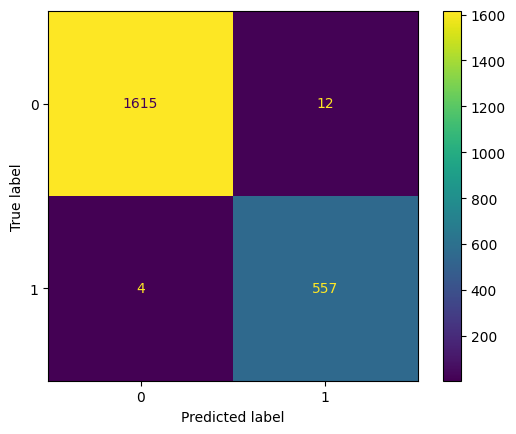

In [17]:
# plot out confusion matrix

cm = confusion_matrix(all_true_labels, all_preds)
ConfusionMatrixDisplay(cm).plot()

9


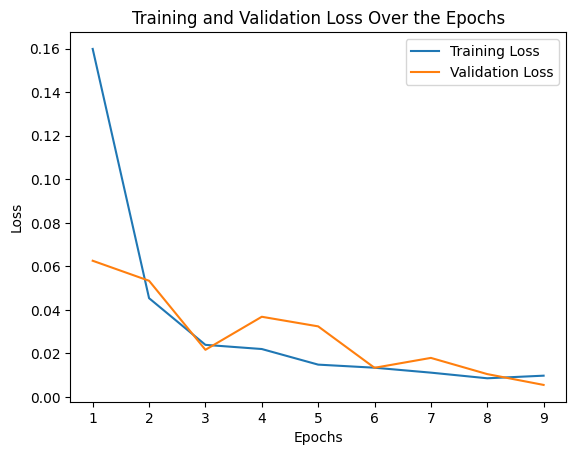

In [18]:
# print learning curves

print(len(train_losses_best))

train_loss_values = [loss.item() for loss in train_losses_best]
val_loss_values = [loss.item() for loss in val_losses_best]

epochs_range = range(1, len(train_loss_values) + 1)

plt.plot(epochs_range, train_loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over the Epochs')
plt.legend()
plt.show()

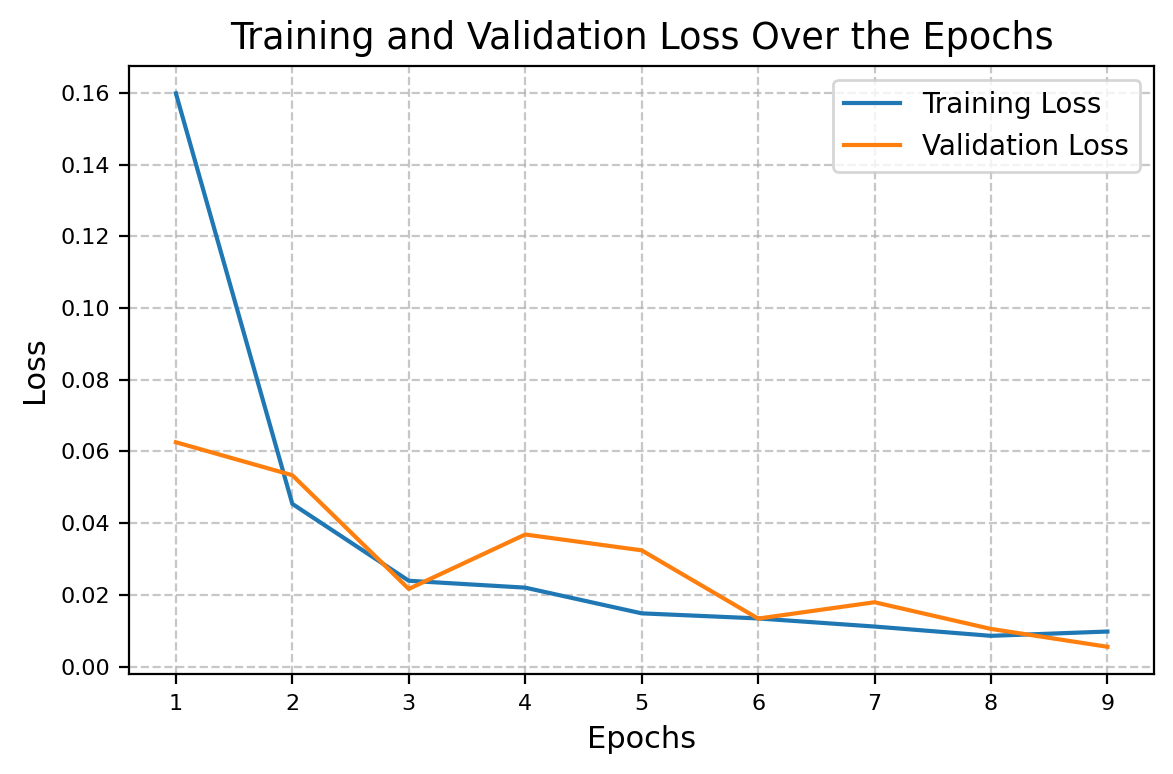

In [28]:
# Set up Arial font plot
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Arial"],
    "font.size": 11,  # Base font size
    "axes.labelsize": 11,  # Size for axis labels
    "legend.fontsize": 10,  # Legend font size
    "xtick.labelsize": 8,  # X-axis tick label size
    "ytick.labelsize": 8,  # Y-axis tick label size
    "figure.figsize": (6, 4),  # Figure size in inches
    "figure.dpi": 200,  # Figure resolution
})

# Verify Arial is available and set fallback if needed
from matplotlib.font_manager import findfont, FontProperties
try:
    findfont(FontProperties(family='Arial'))
except:
    print("Arial font not found, falling back to Helvetica")
    plt.rcParams.update({
        "font.sans-serif": ["Helvetica"]  # Fallback font if Arial is not installed
    })

# Convert losses to values
train_loss_values = [loss.item() for loss in train_losses_best]
val_loss_values = [loss.item() for loss in val_losses_best]
epochs_range = range(1, len(train_loss_values) + 1)

# Create the plot
fig, ax = plt.subplots()

# Plot
ax.plot(epochs_range, train_loss_values, label='Training Loss', color='#1f77b4')
ax.plot(epochs_range, val_loss_values, label='Validation Loss', color='#ff7f0e')

# Set labels
ax.set_xlabel('Epochs', fontweight='normal')  # Normal weight to match document style
ax.set_ylabel('Loss', fontweight='normal')
ax.set_title('Training and Validation Loss Over the Epochs', fontweight='normal')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add legend
ax.legend(frameon=True)  # Added frame to legend for better visibility

# Adjust layout to prevent label clipping
plt.tight_layout()

plt.show()

In [27]:
# save model

# define connector type
if dataset_id == 0:
    connector_type = "ethernet"
elif dataset_id == 2:
    connector_type = "hva280"
elif dataset_id == 4:
    connector_type = "hva630"


if system == "Linux":
    models_dir = "drive/MyDrive/Masters_thesis_clickSense/03_Click_Detection_Model/02_savedWeights"
    models_dir_path = os.path.join(cwd, models_dir)
if system == "Darwin":
    models_dir = "02_savedWeights"
    models_dir_path = os.path.join(cwd, models_dir)

if not os.path.exists(models_dir_path):
    os.makedirs(models_dir_path)

# chek if there any model in the directory
model_files = [f for f in os.listdir(models_dir_path) if f.endswith('.pt')]

# sorting function for files
def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[-1]) # return the last number in file name
        return file_name

def extract_model_number(file_name):
    try:
        #return int(file_name.split('_')[-1].split('.')[0])
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[-1]) # return the last number in file name
    except ValueError:
        print("Latest model number could not be extracted")

connector_model_files = []
for i in model_files:
    if connector_type in i:
        connector_model_files.append(i)
print(len(connector_model_files))

# create file name with the highest number after the model_ prefix
if len(connector_model_files) == 0:
    model_file_name = f"{connector_type}_det_model_{best_training_params[0]}_{best_training_params[1]}_0.pt" # connector type + channel size 1 and channel size 2
else:
    connector_model_files.sort(key=sort_key_func)

    highest_model_number = extract_model_number(connector_model_files[-1])

    model_file_name = f"{connector_type}_det_model_{best_training_params[0]}_{best_training_params[1]}_{highest_model_number + 1}.pt" # connector type + channel size 1 and channel size 2

model_file_path = os.path.join(models_dir_path, model_file_name)
torch.save(best_model_weights, model_file_path) # only saving the state_dict() only saves the learned parameters



7
